# FAMD on one hot encoded features
We use this article as the basis for our encoding method: https://towardsdatascience.com/famd-how-to-generalize-pca-to-categorical-and-numerical-data-2ddbeb2b9210. Factor Analysis of Mixed Data. We'll implement it because it's pretty simple.

The basic idea here is that PCA doesn't really work with one hot encoded data. This method allows us to generalize PCA, and make it applicable to catergorical data that has been one hot encoded.
- Doesn't really work with binary variables: https://stackoverflow.com/questions/40795141/pca-for-categorical-features
- Variance explained just follows proportion of each distinct category -- no meaningful reduction: https://andrewpwheeler.com/2021/06/22/pca-does-not-make-sense-after-one-hot-encoding/

### Split features; combine numerical and ordinal features and scale them
- Split into numerical, ordinal, and categorical features
- Encode ordinal features and concatenate with numerical features
- Scale the features

In [1]:
from data_processor import DataProcessor
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import numpy as np
import matplotlib.pyplot as plt

# gather numerical and ordinal features, and combine them
dp = DataProcessor(pd.read_csv('../data/train.csv'))
num_df = dp.numerical_data()
target = num_df['SalePrice']
num_df.drop('SalePrice', axis=1) 

display(num_df)
target

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageQual,GarageCond,PoolQC,SalePrice
0,65.0,8450,7,5,196.0,706,0,150,856,856,...,5.0,0.0,4.0,2.0,6.0,-1.0,4.0,4.0,-1.0,208500
1,80.0,9600,6,8,0.0,978,0,284,1262,1262,...,5.0,0.0,4.0,3.0,6.0,4.0,4.0,4.0,-1.0,181500
2,68.0,11250,7,5,162.0,486,0,434,920,920,...,5.0,0.0,4.0,2.0,6.0,4.0,4.0,4.0,-1.0,223500
3,60.0,9550,7,5,0.0,216,0,540,756,961,...,5.0,2.0,4.0,2.0,6.0,2.0,4.0,4.0,-1.0,140000
4,84.0,14260,8,5,350.0,655,0,490,1145,1145,...,5.0,0.0,4.0,2.0,6.0,4.0,4.0,4.0,-1.0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,6,5,0.0,0,0,953,953,953,...,5.0,0.0,4.0,3.0,6.0,4.0,4.0,4.0,-1.0,175000
1456,85.0,13175,6,6,119.0,790,163,589,1542,2073,...,4.0,4.0,4.0,3.0,2.0,4.0,4.0,4.0,-1.0,210000
1457,66.0,9042,7,9,0.0,275,0,877,1152,1188,...,5.0,0.0,4.0,2.0,6.0,2.0,4.0,4.0,-1.0,266500
1458,68.0,9717,5,6,0.0,49,1029,0,1078,1078,...,4.0,2.0,0.0,2.0,6.0,-1.0,4.0,4.0,-1.0,142125


0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [2]:
# scale features
scaler = StandardScaler().set_output(transform='pandas')
X_num_scaled = scaler.fit_transform(num_df)
X_num_scaled

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageQual,GarageCond,PoolQC,SalePrice
0,0.212877,-0.207142,0.651479,-0.517200,0.514104,0.575425,-0.288653,-0.944591,-0.459303,-0.793434,...,0.339853,-0.884658,0.303616,-0.409369,0.255978,-0.966583,0.321389,0.302084,-0.064673,0.347273
1,0.645747,-0.091886,-0.071836,2.179628,-0.570750,1.171992,-0.288653,-0.641228,0.466465,0.257140,...,0.339853,-0.884658,0.303616,0.795629,0.255978,1.487697,0.321389,0.302084,-0.064673,0.007288
2,0.299451,0.073480,0.651479,-0.517200,0.325915,0.092907,-0.288653,-0.301643,-0.313369,-0.627826,...,0.339853,-0.884658,0.303616,-0.409369,0.255978,1.487697,0.321389,0.302084,-0.064673,0.536154
3,0.068587,-0.096897,0.651479,-0.517200,-0.570750,-0.499274,-0.288653,-0.061670,-0.687324,-0.521734,...,0.339853,0.265476,0.303616,-0.409369,0.255978,0.505985,0.321389,0.302084,-0.064673,-0.515281
4,0.761179,0.375148,1.374795,-0.517200,1.366489,0.463568,-0.288653,-0.174865,0.199680,-0.045611,...,0.339853,-0.884658,0.303616,-0.409369,0.255978,1.487697,0.321389,0.302084,-0.064673,0.869843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.126303,-0.260560,-0.071836,-0.517200,-0.570750,-0.973018,-0.288653,0.873321,-0.238122,-0.542435,...,0.339853,-0.884658,0.303616,0.795629,0.255978,1.487697,0.321389,0.302084,-0.064673,-0.074560
1456,0.790037,0.266407,-0.071836,0.381743,0.087911,0.759659,0.722112,0.049262,1.104925,2.355701,...,-0.431819,1.415610,0.303616,0.795629,-3.828474,1.487697,0.321389,0.302084,-0.064673,0.366161
1457,0.241735,-0.147810,0.651479,3.078570,-0.570750,-0.369871,-0.288653,0.701265,0.215641,0.065656,...,0.339853,-0.884658,0.303616,-0.409369,0.255978,0.505985,0.321389,0.302084,-0.064673,1.077611
1458,0.299451,-0.080160,-0.795151,0.381743,-0.570750,-0.865548,6.092188,-1.284176,0.046905,-0.218982,...,-0.431819,0.265476,-3.477021,-0.409369,0.255978,-0.966583,0.321389,0.302084,-0.064673,-0.488523


### Encode categorical features
- One hot encode the features
- Each column is divided by the number of 1s in that column, square rooted (called $\sqrt{\mu_m}$; the  square root of the probability of the modality)

In [3]:
X_cat = dp.categorical_data()
display(X_cat)

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,Alley_nan,...,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1456,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1457,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1458,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
for col in X_cat.columns:
    n = X_cat[col].sum()
    X_cat[col] = X_cat[col].apply(lambda x: x / np.sqrt(n))
X_cat

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,Alley_nan,...,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,0.0,0.0,0.0,0.029476,0.0,0.0,0.026225,0.0,0.0,0.027027,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.057354,0.0,0.000000
1,0.0,0.0,0.0,0.029476,0.0,0.0,0.026225,0.0,0.0,0.027027,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.055132,0.000000,0.0,0.000000
2,0.0,0.0,0.0,0.029476,0.0,0.0,0.026225,0.0,0.0,0.027027,...,0.000000,0.125988,0.0,0.0,0.000000,0.000000,0.000000,0.057354,0.0,0.000000
3,0.0,0.0,0.0,0.029476,0.0,0.0,0.026225,0.0,0.0,0.027027,...,0.000000,0.000000,0.0,0.0,0.000000,0.056433,0.000000,0.000000,0.0,0.000000
4,0.0,0.0,0.0,0.029476,0.0,0.0,0.026225,0.0,0.0,0.027027,...,0.000000,0.000000,0.0,0.0,0.130189,0.000000,0.000000,0.057354,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.0,0.0,0.0,0.029476,0.0,0.0,0.026225,0.0,0.0,0.027027,...,0.090536,0.000000,0.0,0.0,0.000000,0.000000,0.055132,0.000000,0.0,0.000000
1456,0.0,0.0,0.0,0.029476,0.0,0.0,0.026225,0.0,0.0,0.027027,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.075593
1457,0.0,0.0,0.0,0.029476,0.0,0.0,0.026225,0.0,0.0,0.027027,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.075593
1458,0.0,0.0,0.0,0.029476,0.0,0.0,0.026225,0.0,0.0,0.027027,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.075593


### Examine data
- Merge numerical and categorical data
- Perform PCA; observe differences in dimensionality

In [5]:
X = pd.concat([X_num_scaled, X_cat], axis=1)
y = target
display(X, y)

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,0.212877,-0.207142,0.651479,-0.517200,0.514104,0.575425,-0.288653,-0.944591,-0.459303,-0.793434,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.057354,0.0,0.000000
1,0.645747,-0.091886,-0.071836,2.179628,-0.570750,1.171992,-0.288653,-0.641228,0.466465,0.257140,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.055132,0.000000,0.0,0.000000
2,0.299451,0.073480,0.651479,-0.517200,0.325915,0.092907,-0.288653,-0.301643,-0.313369,-0.627826,...,0.000000,0.125988,0.0,0.0,0.000000,0.000000,0.000000,0.057354,0.0,0.000000
3,0.068587,-0.096897,0.651479,-0.517200,-0.570750,-0.499274,-0.288653,-0.061670,-0.687324,-0.521734,...,0.000000,0.000000,0.0,0.0,0.000000,0.056433,0.000000,0.000000,0.0,0.000000
4,0.761179,0.375148,1.374795,-0.517200,1.366489,0.463568,-0.288653,-0.174865,0.199680,-0.045611,...,0.000000,0.000000,0.0,0.0,0.130189,0.000000,0.000000,0.057354,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.126303,-0.260560,-0.071836,-0.517200,-0.570750,-0.973018,-0.288653,0.873321,-0.238122,-0.542435,...,0.090536,0.000000,0.0,0.0,0.000000,0.000000,0.055132,0.000000,0.0,0.000000
1456,0.790037,0.266407,-0.071836,0.381743,0.087911,0.759659,0.722112,0.049262,1.104925,2.355701,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.075593
1457,0.241735,-0.147810,0.651479,3.078570,-0.570750,-0.369871,-0.288653,0.701265,0.215641,0.065656,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.075593
1458,0.299451,-0.080160,-0.795151,0.381743,-0.570750,-0.865548,6.092188,-1.284176,0.046905,-0.218982,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.075593


0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [6]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

print(f'{pca.explained_variance_ratio_[:5]} ... {pca.explained_variance_ratio_[-5:]}')
print(f'Number of features: {len(pca.explained_variance_ratio_)}')
print(f'Explained variance ratio: {pca.explained_variance_ratio_.sum()}')

[0.19239183 0.0735022  0.06017245 0.05293903 0.05099472] ... [0.01158305 0.01073677 0.01021369 0.00967761 0.00855869]
Number of features: 30
Explained variance ratio: 0.9567103388217805


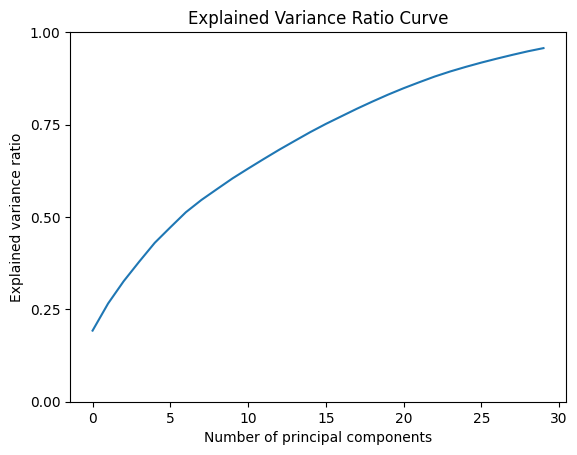

In [7]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('Number of principal components')
plt.ylabel('Explained variance ratio')
plt.yticks([0, 0.25, 0.5, 0.75, 1])
plt.title('Explained Variance Ratio Curve')
plt.show()

Much different results -- 30 features compared to 318. Now the question is, what will performance look like?

### Train and analyze performance
- Design pipeline
- Train, calculate scores

In [8]:
# pipeline and train regression
regr = make_pipeline(PCA(n_components=0.95), LinearRegression())
scoring={'neg_rmse': 'neg_root_mean_squared_error', 
         'neg_mape': 'neg_mean_absolute_percentage_error'}
scores = cross_validate(regr, X, y, scoring=scoring, cv=10, return_train_score=True)

# interpret rmse scores
rmse = -scores['test_neg_rmse'].mean()
nrmse = rmse / y.mean()
percent_nrmse = f'{round(nrmse * 100, 1)}%'

# interpret mape scores
mape = -scores['test_neg_mape'].mean()
percent_mape = f'{round(mape * 100, 1)}%'

f'rmse: {round(rmse)}, normalized rmse: {percent_nrmse}, mape: {percent_mape}'

'rmse: 28136, normalized rmse: 15.6%, mape: 10.6%'

Ladies and gentlemen, mission accomplished.

# Baseline comparisons
## Baseline comparision -- linear regression with numerical data only

In [9]:
# prep data
dp = DataProcessor(pd.read_csv('../data/train.csv'))
df = dp.numerical_data()
y = df['SalePrice']
X = df.drop('SalePrice', axis=1)
display(X, y)

# pipeline and train regression
regr = make_pipeline(StandardScaler(), LinearRegression())
scoring={'neg_rmse': 'neg_root_mean_squared_error', 
         'neg_mape': 'neg_mean_absolute_percentage_error'}
scores = cross_validate(regr, X, y, scoring=scoring, cv=10, return_train_score=True)

# interpret rmse scores
rmse = -scores['test_neg_rmse'].mean()
nrmse = rmse / y.mean()
percent_nrmse = f'{round(nrmse * 100, 1)}%'

# interpret mape scores
mape = -scores['test_neg_mape'].mean()
percent_mape = f'{round(mape * 100, 1)}%'

f'rmse: {round(rmse)}, normalized rmse: {percent_nrmse}, mape: {percent_mape}'

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageQual,GarageCond,PoolQC
0,65.0,8450,7,5,196.0,706,0,150,856,856,...,2.0,5.0,0.0,4.0,2.0,6.0,-1.0,4.0,4.0,-1.0
1,80.0,9600,6,8,0.0,978,0,284,1262,1262,...,0.0,5.0,0.0,4.0,3.0,6.0,4.0,4.0,4.0,-1.0
2,68.0,11250,7,5,162.0,486,0,434,920,920,...,2.0,5.0,0.0,4.0,2.0,6.0,4.0,4.0,4.0,-1.0
3,60.0,9550,7,5,0.0,216,0,540,756,961,...,0.0,5.0,2.0,4.0,2.0,6.0,2.0,4.0,4.0,-1.0
4,84.0,14260,8,5,350.0,655,0,490,1145,1145,...,2.0,5.0,0.0,4.0,2.0,6.0,4.0,4.0,4.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,6,5,0.0,0,0,953,953,953,...,5.0,5.0,0.0,4.0,3.0,6.0,4.0,4.0,4.0,-1.0
1456,85.0,13175,6,6,119.0,790,163,589,1542,2073,...,0.0,4.0,4.0,4.0,3.0,2.0,4.0,4.0,4.0,-1.0
1457,66.0,9042,7,9,0.0,275,0,877,1152,1188,...,2.0,5.0,0.0,4.0,2.0,6.0,2.0,4.0,4.0,-1.0
1458,68.0,9717,5,6,0.0,49,1029,0,1078,1078,...,2.0,4.0,2.0,0.0,2.0,6.0,-1.0,4.0,4.0,-1.0


0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

'rmse: 35135, normalized rmse: 19.4%, mape: 12.3%'